In [28]:
import yfinance as yf
import yahoo_fin.stock_info as si
import pandas as pd
import numpy as np
import datetime as dt
from sklearn.linear_model import LinearRegression
from matplotlib import pyplot as plt
import plotly.graph_objects as go

In [129]:
################# input ticker ###############
ticker = "goog"

stock = yf.Ticker(ticker)

In [5]:
######################## financial analysis ####################
unit = 'year'

if unit == 'quart':
    fin = stock.quarterly_financials
    bs = stock.quarterly_balance_sheet
elif unit == 'year':
    fin = stock.financials
    bs = stock.balance_sheet

if(fin.shape[0] == 0):
    print('Invalid Ticker')
else:
    ## gross
    rev_total = fin.loc['Total Revenue', :]
    rev_cost = fin.loc['Cost Of Revenue', :]
    gross_pchg = [round((rev_total[i]-rev_total[i+1])/rev_total[i+1], 3) for i in range(len(rev_total)-1)]+[0]
    gross_pchg = pd.DataFrame(gross_pchg)
    gross_pchg.index = rev_total.index
  
    ## gross marging
    gmargin = (rev_total-rev_cost)/rev_total
    gmargin_pchg = [round((gmargin[i]-gmargin[i+1])/gmargin[i+1], 3) for i in range(len(gmargin)-1)]+[0]
    gmargin_pchg = pd.DataFrame(gmargin_pchg)
    gmargin_pchg.index = gmargin.index
    
    gross_smry = pd.concat([rev_total, gross_pchg, gmargin, gmargin_pchg], axis = 1)
    gross_smry.columns = ['Gross', 'Gross_PCHG', 'Gross_Margin', 'GM_PCHG']
    
    ## net income
    ninc = fin.loc['Net Income', :]
    ninc_pchg = [round((ninc[i] - ninc[i+1])/ninc[i+1], 3) for i in range(len(ninc)-1)]+[0]
    ninc_pchg = pd.DataFrame(ninc_pchg)
    ninc_pchg.index = ninc.index
    
    ninc_smry = pd.concat([ninc, ninc_pchg], axis = 1)
    ninc_smry.columns = ['Net Income', 'Net Income PCHG']
    
    ## PB ratio 
    pb_ratio = stock.info['marketCap']/bs.loc['Net Tangible Assets', :][0]

    ## Ratio of totoal liab and total asset
    lia_ast = bs.loc['Total Liab', :]/bs.loc['Total Assets', :]

    ## Ratio of current totoal liab and current total asset
    lia_ast_cur = bs.loc['Total Current Liabilities', :]/bs.loc['Total Current Assets', :]
    
    ## cash/liab
    cash_lia_cur = bs.loc['Cash', :]/bs.loc['Total Current Liabilities', :]
    cash_lia = bs.loc['Cash', :]/bs.loc['Total Liab', :]
    
    ## (cash+short_term_invest)/laib
    if 'Short Term Investments' in bs.index:
        cain_lia_cur = (bs.loc['Cash', :] + bs.loc['Short Term Investments',:])/bs.loc['Total Current Liabilities', :]
        cain_lia = (bs.loc['Cash', :] + bs.loc['Short Term Investments',:])/bs.loc['Total Liab', :]
    else:
        cain_lia_cur = cash_lia_cur
        cain_lia = cash_lia 
    
    dfasset = [lia_ast_cur, lia_ast, cash_lia_cur, cash_lia, cain_lia_cur, cain_lia]
    asset_smry = pd.DataFrame(dfasset).T
    asset_smry.columns = ['Cur_Liab/Asset', 'Tot_Liab/Asset', 'Cur_Cash/Liab', 'Tot_Cash/Liab', 'Cur_CI/Liab', 'Tot_CI/Liab']
    
    print(gross_smry)
    print(ninc_smry)
    print(round(pb_ratio, 3))
    print(round(asset_smry, 3))

                    Gross  Gross_PCHG Gross_Margin  GM_PCHG
                                                           
2022-01-02  93775000000.0       0.136     0.681632    0.038
2021-01-03  82584000000.0       0.006     0.656992   -0.011
2019-12-29  82059000000.0       0.006     0.664193   -0.006
2018-12-30  81581000000.0       0.000     0.667925    0.000
               Net Income  Net Income PCHG
                                          
2022-01-02  20878000000.0            0.419
2021-01-03  14714000000.0           -0.027
2019-12-29  15119000000.0           -0.012
2018-12-30  15297000000.0            0.000
-33.773
            Cur_Liab/Asset  Tot_Liab/Asset  Cur_Cash/Liab  Tot_Cash/Liab  \
                                                                           
2022-01-02             NaN             NaN            NaN            NaN   
2021-01-03           0.829           0.638          0.329          0.125   
2019-12-29           0.794           0.623          0.481          0.1

In [6]:
############## discount cash flow ############
unit = 'year'

if unit == 'quart':
    csh = stock.quarterly_cashflow
elif unit == 'year':
    csh = stock.cashflow
    
period = 10
fcsh = csh.loc['Total Cash From Operating Activities', :] + csh.loc['Capital Expenditures', :]
fcsh_chg = [(fcsh[i] - fcsh[i+1])/fcsh[i+1] for i in range(len(fcsh)-1)]
max_chg = np.max(fcsh_chg)
ave_chg = np.mean(fcsh_chg)
fcsh_ft = [fcsh[0]*(1+ave_chg)**n for n in range(period)]
csh_cur = np.sum([fcsh_ft[n-1]/(1+0.0177)**n for n in range(1, period+1)])/10**9
print(fcsh)
print(csh_cur)


2022-01-02             NaN
2021-01-03    2.018900e+10
2019-12-29    1.991800e+10
2018-12-30    1.853100e+10
dtype: float64
nan


In [7]:
################ basic info #####################
variables = ['revenueGrowth', 'targetLowPrice', 'targetMedianPrice', \
'targetHighPrice', 'forwardPE', 'trailingPE', 'priceToBook', 'pegRatio', \
'quickRatio', 'shortRatio', 'payoutRatio', 'dividendYield', \
'enterpriseToRevenue', 'heldPercentInstitutions', 'beta', 'recommendationKey']

skinfo = stock.info
info = list(map(skinfo.get, variables))
basic_info = pd.DataFrame(info)
basic_info.index = variables
basic_info

,0
revenueGrowth,0.104
targetLowPrice,163
targetMedianPrice,186
targetHighPrice,215
forwardPE,15.274136
trailingPE,21.479252
priceToBook,6.282685
pegRatio,2.52
quickRatio,None
shortRatio,1.89


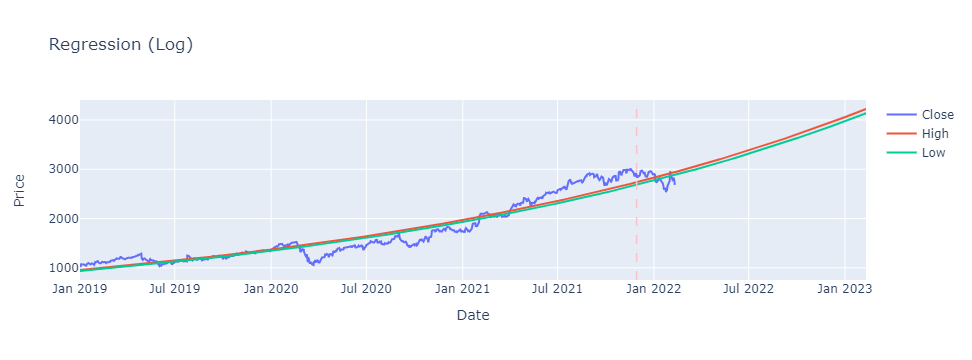

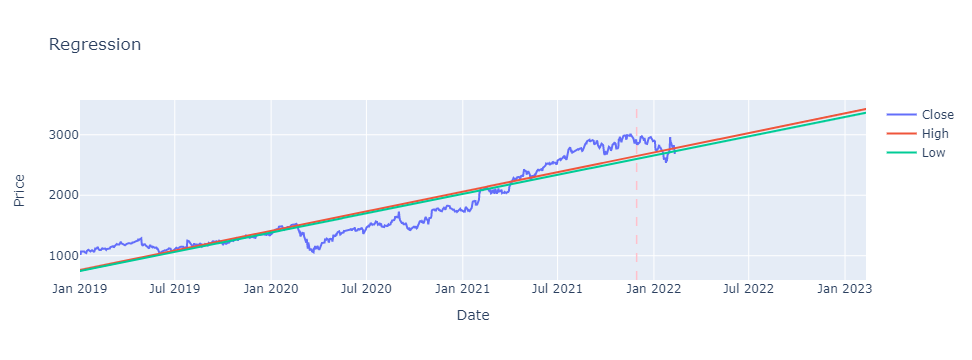

In [130]:
############### price range ####################
stdate = '2019-01-01'
eddate = '2021-12-01'
tdy = dt.datetime.today()
#tdy = '2007-01-01'
preddays = 366

stock = yf.Ticker(ticker)
skhist_tr = stock.history(start = stdate, end = eddate)
skhist_te = stock.history(start = stdate, end = tdy)
skhigh_tr = skhist_tr['High']
sklow_tr = skhist_tr['Low']
skopen_tr = skhist_tr['Open']
skclose_tr = skhist_tr['Close']
skopen_te = skhist_te['Open']
skclose_te = skhist_te['Close']
dr_tr = (skclose_tr - skopen_tr)/skclose_tr
dr_te = (skclose_te - skopen_te)/skclose_te
dates_tr = skhist_tr.index
dates_te = skhist_te.index

time_tr = np.array((dates_tr - dates_tr[0])/np.timedelta64(1, 'D')).reshape(-1, 1)
time_te = np.array((dates_te - dates_te[0])/np.timedelta64(1, 'D')).reshape(-1, 1)
pred_tm = np.array(range(int(time_te[-1])+1, int(time_te[-1])+preddays)).reshape(-1, 1)
time_pred = np.concatenate((time_te, pred_tm))

tm_tr = [dt.date.fromisoformat(stdate) + dt.timedelta(days = int(time_tr[i])) for i in range(len(time_tr))]
tm_te = [dt.date.fromisoformat(stdate) + dt.timedelta(days = int(time_te[i])) for i in range(len(time_te))]
tm_pred = [dt.date.fromisoformat(stdate) + dt.timedelta(days = int(time_pred[i])) for i in range(len(time_pred))]

## regression on log(price)

reg_high_log = LinearRegression().fit(time_tr, np.log(skhigh_tr))
pred_high1 = np.exp(reg_high_log.predict(time_pred))

reg_low_log = LinearRegression().fit(time_tr, np.log(sklow_tr))
pred_low1 = np.exp(reg_low_log.predict(time_pred))

## regression on price
reg_high = LinearRegression().fit(time_tr, skhigh_tr)
pred_high2 = reg_high.predict(time_pred)

reg_low = LinearRegression().fit(time_tr, sklow_tr)
pred_low2 = reg_low.predict(time_pred)

## plots
fig1 = go.Figure(data = go.Scatter(x = tm_te, y = skclose_te, name = 'Close'))
fig1.add_trace(go.Scatter(x = tm_pred, y = pred_high1, name = 'High'))
fig1.add_trace(go.Scatter(x = tm_pred, y = pred_low1, name = 'Low'))
fig1.add_vline(x = tm_tr[-1], line_width = 1.5, line_dash = 'dash', line_color = 'pink')
fig1.update_layout(title='Regression (Log)', xaxis_title='Date', yaxis_title='Price')
fig1.show()

fig2 = go.Figure(data = go.Scatter(x = tm_te, y = skclose_te, name = 'Close'))
fig2.add_trace(go.Scatter(x = tm_pred, y = pred_high2, name = 'High'))
fig2.add_trace(go.Scatter(x = tm_pred, y = pred_low2, name = 'Low'))
fig2.add_vline(x = tm_tr[-1], line_width = 1.5, line_dash = 'dash', line_color = 'pink')
fig2.update_layout(title='Regression', xaxis_title='Date', yaxis_title='Price')
fig2.show()


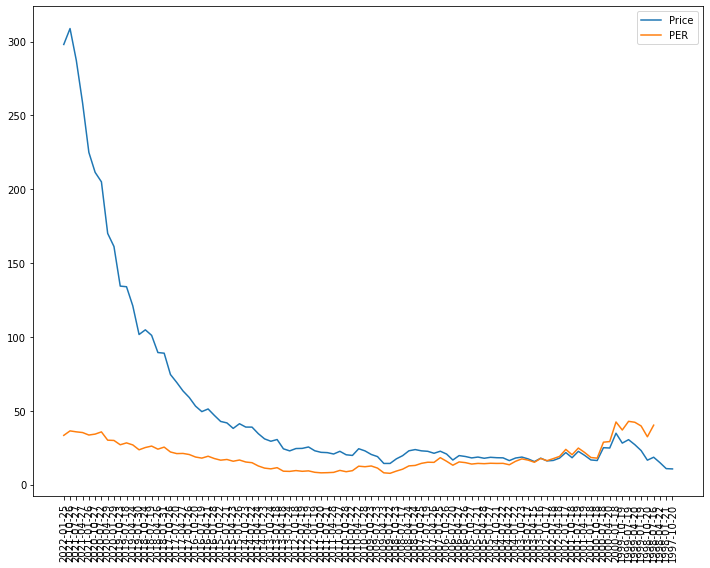

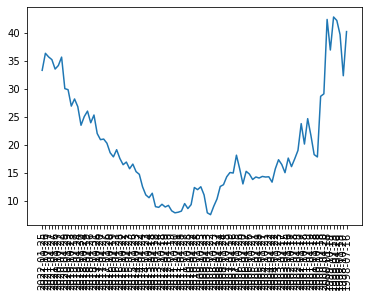

In [12]:
##################### historical PE ratio #####################
## eps
stock = yf.Ticker(ticker)
earning_tmp1 = si.get_earnings_history(ticker)
earning_tmp2 = pd.DataFrame(earning_tmp1)
earning = earning_tmp2[earning_tmp2['startdatetimetype'] != 'TAS']

# actual earning
earn_act = earning.dropna()

# actual eps date
earntime = list(earn_act['startdatetime'].str[:10])

# price on actual earning date
price_cls = []
for i in range(len(earntime)):
    skprice = stock.history(start = dt.date.fromisoformat(earntime[i])-dt.timedelta(days = 5), end = earntime[i])
    price_cl = np.mean(skprice['Close'])
    price_cls.append(price_cl)

# actual eps
eps_act = earn_act['epsactual']

# actual ttm eps
eps_ttms = [np.sum(eps_act[i:(i+4)]) for i in range(0, len(eps_act)-3)]

# pe ratios
pers = np.array(price_cls[0:-3])/np.array(eps_ttms)

plt.figure(figsize = (12, 9))
plt.plot(earntime, price_cls)
plt.plot(pers)
plt.xticks(rotation = 90)
plt.legend(['Price', 'PER'])
plt.show()

plt.plot(earntime[:-3], pers)
plt.xticks(rotation = 90)
plt.show()

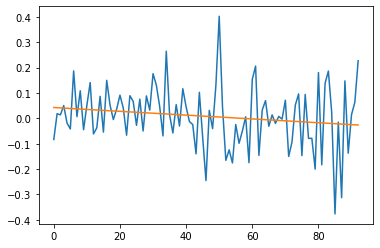

In [51]:
##### plot growth of per
perg = np.array([(pers[i]-pers[i+1])/pers[i+1] for i in range(len(pers)-1)]).reshape(-1, 1)
indeces = np.array(range(len(perg))).reshape(-1, 1)
fit_perg = LinearRegression().fit(indeces, perg)
perg_pred = fit_perg.predict(indeces)
plt.plot(perg)
plt.plot(perg_pred)
plt.show()

In [15]:
summary = pd.DataFrame([earntime, price_cls, pers]).T
summary.columns = ['Date', 'Close Price', 'PER']
print(summary)
print(np.median(summary['PER'][:20]))

          Date Close Price        PER
0   2022-01-25       298.0  33.296089
1   2021-10-26  308.785085  36.327657
2   2021-07-27  287.210358  35.678305
3   2021-04-27  258.389486  35.202927
4   2021-01-26  224.931224  33.521792
..         ...         ...        ...
93  1998-10-20   16.489993  32.333319
94  1998-07-16   18.489172  40.193852
95  1998-04-22   14.816328       None
96  1998-01-21   10.774391       None
97  1997-10-20   10.572171       None

[98 rows x 3 columns]
27.563697184322038


In [105]:

list(range(3, 2))

[]